# Advanced Data Science &amp; Python for Finance  <br><br> Final Project <br><br> Part 2 - Common Financial Analysis
-----

FIN580-59305 Spring 2020

Name: Danni Chen <br>
NetID: dannic3

Master of Science in Finance, University of Illinois at Urbana-Champaign.

* https://www.linkedin.com/in/dannie-chen-dc/

#### Instruction: Part 2 - Common Financial Analysis - Total Points: 20

For this section, you will select an industry that is part of the new clean S&P 1500 dataset (sp1500.csv). You will focus on this industry for the remainder of the project.

2.1. Choose five companies in your selected industry. For each company you selected, download 120 trading days of data using the Intrinio API. 

2.2 Plot the closing price of each security on the same chart. 

2.3 Calculate and plot the returns and log returns for each security. In a short paragraph analyze the returns. Plot the distribution of the returns for each security. In a short paragraph analyze the returns distribution. 

2.4 Moving/Window Statistics: (a) Create a five day moving average using close price. (b) Create a five day moving high price (max()) (c) Create a five day moving low price (min()). 

2.5 On the same chart plot the closing price of each security including the five day moving average, moving high price and moving low price.

Submit a clean and organized notebook and the corresponding dataset answering the questions for this part.

## Packages and Settings

In [2]:
!pip install configparser
!pip install intrinio_sdk

You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 706kB 445kB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import intrinio_sdk
import configparser as cp

## Read the cleaned csv data

In [4]:
sp1500_df = pd.read_csv("../../data/SP1500.csv")

**I want to select an industry with more than 25 companies to conduct analysis on.<br>Then, which industries have at least 25 companies?**

In [5]:
pd.value_counts(sp1500_df['industry'])[(pd.value_counts(sp1500_df['industry'])>25)]

Regional Banks                            88
Health Care Equipment                     42
Industrial Machinery                      41
Oil and Gas Exploration and Production    32
Application Software                      28
Semiconductors                            28
Packaged Foods and Meats                  26
Property and Casualty Insurance           26
Name: industry, dtype: int64

## In this section, I would like to select "Application Software" industry.

**Create a new dataframe with only the "Application Software" industry selected**

In [6]:
sp1500_df = pd.read_csv("../../data/SP1500.csv")
software = sp1500_df[sp1500_df['industry']=='Application Software']
software.shape

(28, 13)

## 2.1 Download Data from Intrinio API for Selected 5 Companies
#### 2 steps:
* 2.1.1 Download Data from Intrinio API for Application Software Industry for 120 trading days
* 2.1.2 Choose five companies in this industry and prepare the dataset

### 2.1.1 Download Data from Intrinio API for Application Software Industry

**Connect to Intrinio API using sandbox API key**

In [7]:
cfg = cp.ConfigParser()
cfg.read('../../resources/credentials.cfg')

['../../resources/credentials.cfg']

In [8]:
API_KEY = cfg['intrinio']['app_key']

intrinio_sdk.ApiClient().configuration.api_key['api_key'] = API_KEY

security_api = intrinio_sdk.SecurityApi()

** Making multiple request to Intrinio API **

In [9]:
tickers = software['ticker'].tolist()
start_date = '2019-11-08'
end_date = '2020-05-01'
frequency = 'daily' 

dfs = []
for ticker in tickers:
    next_page = ''
    response = security_api.get_security_stock_prices(ticker,
                                                      start_date = start_date,
                                                      end_date = end_date)
    df = [p.to_dict() for p in response.stock_prices]
    next_page = response.next_page
    if next_page != None:
        response = security_api.get_security_stock_prices(ticker,
                                                          start_date = start_date,
                                                          end_date = end_date,
                                                          next_page = next_page)    
        df.extend(p.to_dict() for p in response.stock_prices)
    df = pd.DataFrame.from_dict(df)
    df['secid'] = ticker
    dfs.append(df)

In [10]:
software_df = pd.concat(dfs)
software_df.index = pd.DatetimeIndex(software_df['date'])
software_df = software_df.drop('date', axis=1)
software_df.index.name = None

#SORT DATETIME INDEX
software_df = software_df.sort_index()
software_df.shape

(3360, 13)

#### Check: whether or not this dataset includes 120 trading days

In [11]:
# Number of Business days
# This is not the same as the number of trading days during this period.
len(pd.bdate_range('2019-11-08','2020-05-01'))

126

In [12]:
# Check: Number of Trading days
len(software_df.index)/len(software_df['secid'].unique())

120.0

In [13]:
software_df.head()

,adj_close,adj_high,adj_low,adj_open,adj_volume,close,frequency,high,intraperiod,low,open,volume,secid
2019-11-08,42.686604,43.32342,42.16919,42.567201,362714.0,42.90,daily,43.540,False,42.38,42.78,362714.0,EBIX
2019-11-08,292.460000,292.46000,288.48000,290.020000,1628523.0,292.46,daily,292.460,False,288.48,290.02,1628523.0,ADBE
2019-11-08,23.930000,24.07000,23.40000,23.450000,121383.0,23.93,daily,24.070,False,23.40,23.45,121383.0,AGYS
2019-11-08,45.370000,47.32500,45.17000,47.050000,419935.0,45.37,daily,47.325,False,45.17,47.05,419935.0,ALRM
2019-11-08,224.310000,224.94500,221.83000,223.950000,597404.0,224.31,daily,224.945,False,221.83,223.95,597404.0,ANSS


In [14]:
software_df.to_csv("../../data/software_df.csv")

### 2.1.2 Choose five companies in Application Software industry

In [15]:
# Choose 5 companies with highest pct_price_change_ytd in the application software industry
software_5comp = software.sort_values(by=['pct_price_change_ytd'], ascending=False).head(5)
software_5comp

,company,ticker,price_close,pct_price_change_lastday,pct_pricechange_30day,pct_price_change_ytd,pct_price_change_12_month,price_earnings_ratio,price_bookvalue_ratio,marketcap_mm,revenue_mm,exchange,industry
289,"Citrix Systems, Inc.",CTXS,142.58,-1.68,2.47,28.57,41.48,24.90x,NM,17601.59,3152.37,NasdaqGS,Application Software
214,"Cadence Design Systems, Inc.",CDNS,75.84,-6.52,16.25,9.34,10.65,21.42x,9.81x,21298.39,2377.53,NasdaqGS,Application Software
1232,"Synopsys, Inc.",SNPS,149.64,-4.76,18.80,7.50,24.61,48.05x,5.42x,22479.99,3374.67,NasdaqGS,Application Software
1358,"Tyler Technologies, Inc.",TYL,314.78,-1.84,7.96,4.92,39.34,75.79x,7.31x,12516.17,1115.9,NYSE,Application Software
21,Adobe Inc.,ADBE,343.84,-2.77,14.15,4.25,21.35,51.99x,15.87x,165662.40,11661.3,NasdaqGS,Application Software


In [16]:
selected_tickers = software_5comp['ticker'].tolist()
selected_tickers

['CTXS', 'CDNS', 'SNPS', 'TYL', 'ADBE']

In [17]:
software_df_5comps = software_df[software_df['secid'].isin(selected_tickers)]
software_df_5comps.tail()

,adj_close,adj_high,adj_low,adj_open,adj_volume,close,frequency,high,intraperiod,low,open,volume,secid
2020-05-01,343.84,350.3099,340.26,347.24,2578615.0,343.84,daily,350.3099,False,340.26,347.24,2578615.0,ADBE
2020-05-01,149.64,155.4900,148.20,153.68,1188283.0,149.64,daily,155.4900,False,148.20,153.68,1188283.0,SNPS
2020-05-01,142.58,144.7900,140.46,143.62,1545690.0,142.58,daily,144.7900,False,140.46,143.62,1545690.0,CTXS
2020-05-01,75.84,80.0000,75.51,79.59,2894628.0,75.84,daily,80.0000,False,75.51,79.59,2894628.0,CDNS
2020-05-01,314.78,318.0000,311.57,318.00,326302.0,314.78,daily,318.0000,False,311.57,318.00,326302.0,TYL


In [44]:
# Check: Whether the number of trading days is 120
len(software_df_5comps.index)/len(software_df_5comps['secid'].unique())

120.0

## 2.2 Plot the Closing Price of the selected 5 Securities

In [45]:
# Tickers for the 5 companies to be plot:'CTXS', 'CDNS', 'SNPS', 'TYL', 'ADBE'.
ADBE = software_df_5comps[software_df_5comps["secid"] == "ADBE"]  # Adobe Inc.
CTXS = software_df_5comps[software_df_5comps["secid"] == "CTXS"]  # Citrix Systems, Inc.
CDNS = software_df_5comps[software_df_5comps["secid"] == "CDNS"]  # Cadence Design Systems, Inc.
SNPS = software_df_5comps[software_df_5comps["secid"] == "SNPS"]  # Synopsys, Inc.
TYL = software_df_5comps[software_df_5comps["secid"] == "TYL"]    # Tyler Technologies, Inc.

In [46]:
# Create a dataframe including the closing price information for the 5 companies
close_5comps = pd.DataFrame({"ADBE":ADBE['close'],
                           "CTXS":CTXS['close'],
                           "CDNS":CDNS['close'],
                           "SNPS":SNPS['close'],
                           "TYL":TYL['close']})
close_5comps.head()

,ADBE,CTXS,CDNS,SNPS,TYL
2019-11-08,292.46,110.73,67.10,136.21,277.72
2019-11-11,290.27,111.31,67.45,137.81,279.62
2019-11-12,291.72,111.43,67.58,138.89,278.38
2019-11-13,293.54,111.94,67.21,139.20,279.89
2019-11-14,294.53,111.39,67.16,138.13,282.28


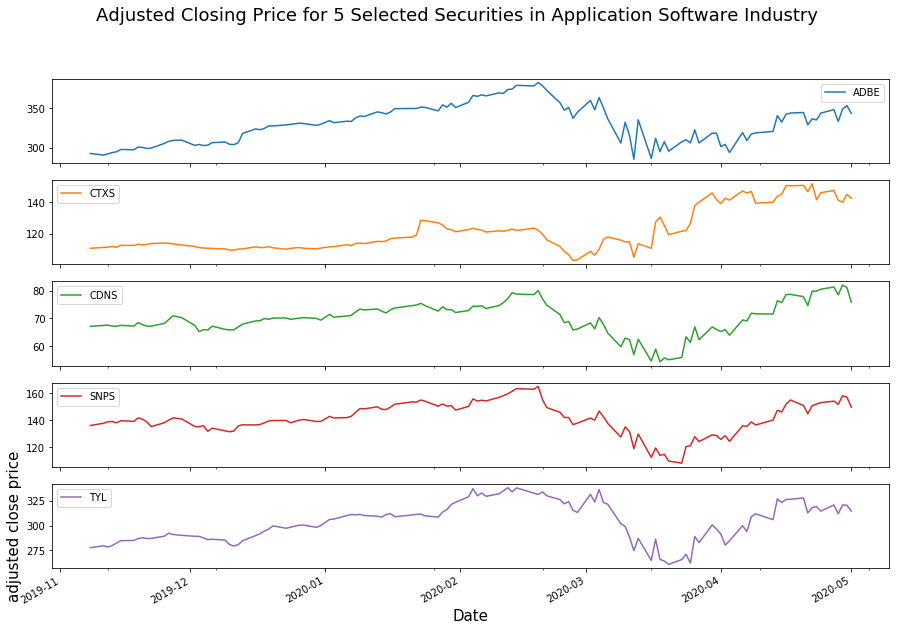

In [47]:
close_5comps.plot(subplots = True,figsize=(15,10))
plt.suptitle("Adjusted Closing Price for 5 Selected Securities in Application Software Industry", size = 18)
plt.xlabel("Date", size = 15)
plt.ylabel('adjusted close price', size = 15)
plt.show()

 <a id='commonanalyses'></a>
## Common Financial Analyses

## 2.3 Returns and Log Returns for Each Security

In [57]:
# Caculate the Daily Returns
ADBE_d_returns = ADBE['close'].pct_change()
ADBE_d_returns.fillna(0, inplace=True)

CTXS_d_returns = CTXS['close'].pct_change()
CTXS_d_returns.fillna(0, inplace=True)

CDNS_d_returns = CDNS['close'].pct_change()
CDNS_d_returns.fillna(0, inplace=True)

SNPS_d_returns = SNPS['close'].pct_change()
SNPS_d_returns.fillna(0, inplace=True)

TYL_d_returns = TYL['close'].pct_change()
TYL_d_returns.fillna(0, inplace=True)

In [58]:
# Caculate the Log Returns
ADBE_log_returns = np.log(ADBE['close'] / ADBE['close'].shift(1))
ADBE_log_returns.fillna(0, inplace=True)

CTXS_log_returns = np.log(CTXS['close'] / CTXS['close'].shift(1))
CTXS_log_returns.fillna(0, inplace=True)

CDNS_log_returns = np.log(CDNS['close'] / CDNS['close'].shift(1))
CDNS_log_returns.fillna(0, inplace=True)

SNPS_log_returns = np.log(SNPS['close'] / SNPS['close'].shift(1))
SNPS_log_returns.fillna(0, inplace=True)

TYL_log_returns = np.log(TYL['close'] / TYL['close'].shift(1))
TYL_log_returns.fillna(0, inplace=True)

In [59]:
ADBE.loc[:,'daily_returns'] = ADBE_d_returns
CTXS.loc[:,'daily_returns'] = CTXS_d_returns
CDNS.loc[:,'daily_returns'] = CDNS_d_returns
SNPS.loc[:,'daily_returns'] = SNPS_d_returns
TYL.loc[:,'daily_returns'] = TYL_d_returns

ADBE.loc[:,'log_daily_returns'] = ADBE_log_returns
CTXS.loc[:,'log_daily_returns'] = CTXS_log_returns
CDNS.loc[:,'log_daily_returns'] = CDNS_log_returns
SNPS.loc[:,'log_daily_returns'] = SNPS_log_returns
TYL.loc[:,'log_daily_returns'] = TYL_log_returns

### 2.3.1 Plot the daily return and log daily return for the 5 securities

#### (1) Plot the Returns and Log Returns for Adobe Inc.

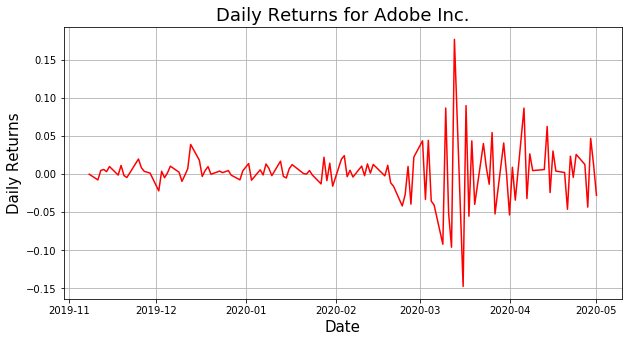

In [60]:
plt.figure(figsize=(10,5))
plt.plot(ADBE.index, ADBE_d_returns,"r", label = "daily returns")
plt.grid(True)
plt.xlabel('Date', size = 15)
plt.ylabel('Daily Returns', size = 15)
plt.title("Daily Returns for Adobe Inc.", size = 18)
plt.show()

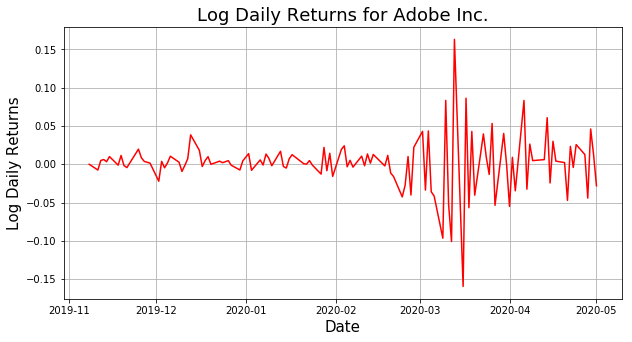

In [61]:
plt.figure(figsize=(10,5))
plt.plot(ADBE.index, ADBE_log_returns,"r", label = "log daily returns")
plt.grid(True)
plt.xlabel('Date', size = 15)
plt.ylabel('Log Daily Returns', size = 15)
plt.title("Log Daily Returns for Adobe Inc.", size = 18)
plt.show()

#### (2) Plot the Returns and Log Returns for Citrix Systems Inc.

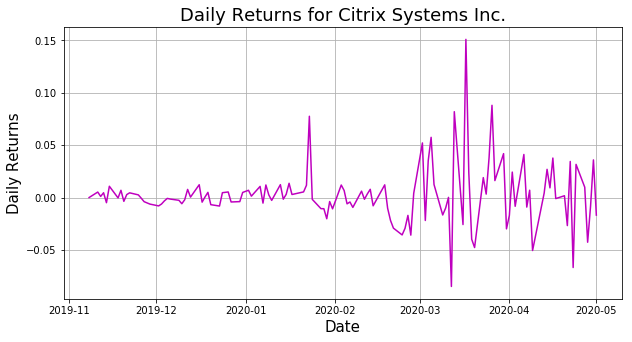

In [62]:
# Plot the Returns and Log Returns for Citrix Systems Inc.
plt.figure(figsize=(10,5))
plt.plot(CTXS.index, CTXS_d_returns,"m", label = "daily returns")
plt.grid(True)
plt.xlabel('Date', size = 15)
plt.ylabel('Daily Returns', size = 15)
plt.title("Daily Returns for Citrix Systems Inc.", size = 18)
plt.show()

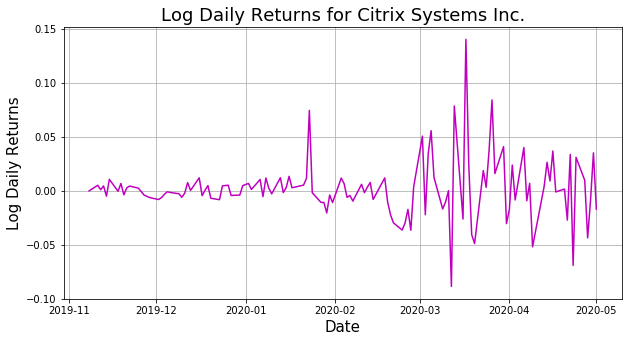

In [63]:
plt.figure(figsize=(10,5))
plt.plot(CTXS.index, CTXS_log_returns,"m", label = "log daily returns")
plt.grid(True)
plt.xlabel('Date', size = 15)
plt.ylabel('Log Daily Returns', size = 15)
plt.title("Log Daily Returns for Citrix Systems Inc.", size = 18)
plt.show()

#### (3) Plot the Returns and Log Returns for Cadence Design Systems Inc.

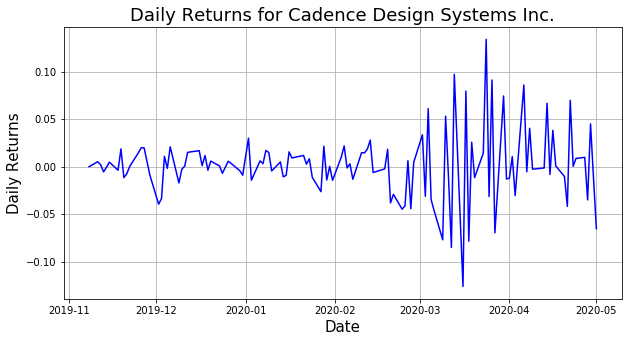

In [64]:
plt.figure(figsize=(10,5))
plt.plot(CDNS.index, CDNS_d_returns,"b", label = "daily returns")
plt.grid(True)
plt.xlabel('Date', size = 15)
plt.ylabel('Daily Returns', size = 15)
plt.title("Daily Returns for Cadence Design Systems Inc.", size = 18)
plt.show()

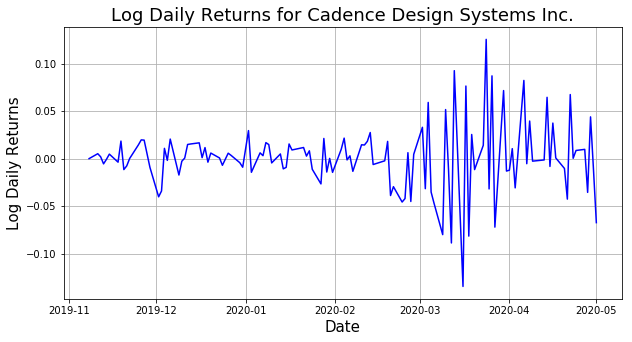

In [65]:
plt.figure(figsize=(10,5))
plt.plot(CDNS.index, CDNS_log_returns,"b", label = "log daily returns")
plt.grid(True)
plt.xlabel('Date', size = 15)
plt.ylabel('Log Daily Returns', size = 15)
plt.title("Log Daily Returns for Cadence Design Systems Inc.", size = 18)
plt.show()

#### (4) Plot the Returns and Log Returns for Synopsys Inc.

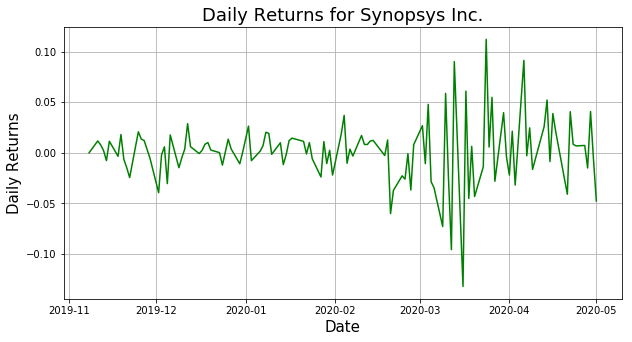

In [66]:
plt.figure(figsize=(10,5))
plt.plot(SNPS.index, SNPS_d_returns,"g", label = "daily returns")
plt.grid(True)
plt.xlabel('Date', size = 15)
plt.ylabel('Daily Returns', size = 15)
plt.title("Daily Returns for Synopsys Inc.", size = 18)
plt.show()

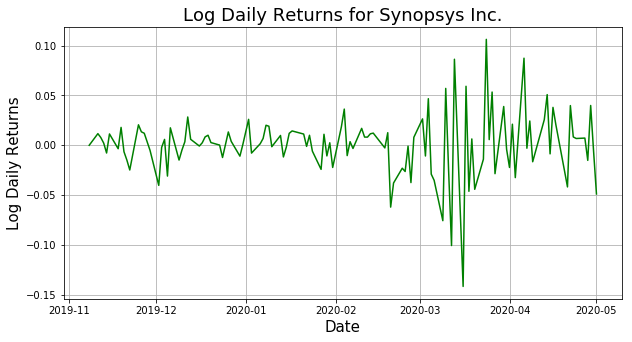

In [67]:
plt.figure(figsize=(10,5))
plt.plot(SNPS.index, SNPS_log_returns,"g", label = "log daily returns")
plt.grid(True)
plt.xlabel('Date', size = 15)
plt.ylabel('Log Daily Returns', size = 15)
plt.title("Log Daily Returns for Synopsys Inc.", size = 18)
plt.show()

#### (5) Plot the Returns and Log Returns for Tyler Technologies Inc.

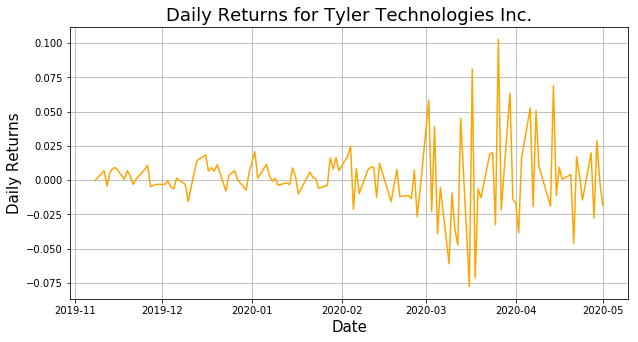

In [68]:
plt.figure(figsize=(10,5))
plt.plot(TYL.index, TYL_d_returns,"orange", label = "daily returns")
plt.grid(True)
plt.xlabel('Date', size = 15)
plt.ylabel('Daily Returns', size = 15)
plt.title("Daily Returns for Tyler Technologies Inc.", size = 18)
plt.show()

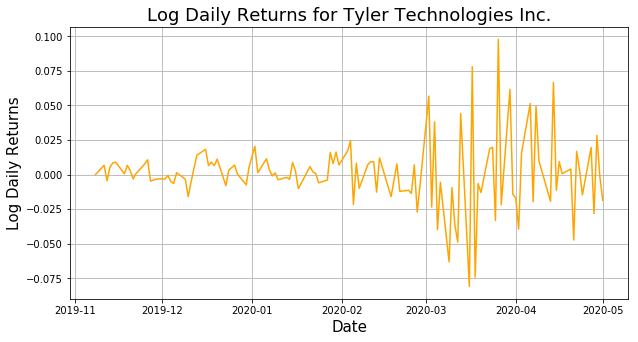

In [69]:
plt.figure(figsize=(10,5))
plt.plot(TYL.index, TYL_log_returns,"orange", label = "log daily returns")
plt.grid(True)
plt.xlabel('Date', size = 15)
plt.ylabel('Log Daily Returns', size = 15)
plt.title("Log Daily Returns for Tyler Technologies Inc.", size = 18)
plt.show()

### Summary of Return Plots:  
#### The returns for the 5 securities have similar patterns:
#### The daily returns (daily percentage change) and log daily returns of closing price for the five companies are stationary processes. Returns and log returns look very similar. The means are all about zero, and the price are fluctuating up and down near the mean level. 
#### The volatility of returns for the 5 securities INCREASED tremendously since the end of February 2020, which might be mainly due to the outbreak of COVID-19 in the US. Before February 2020, the volatilities of the returns are relatively small.

### 2.3.2 Distribution of the returns for each security

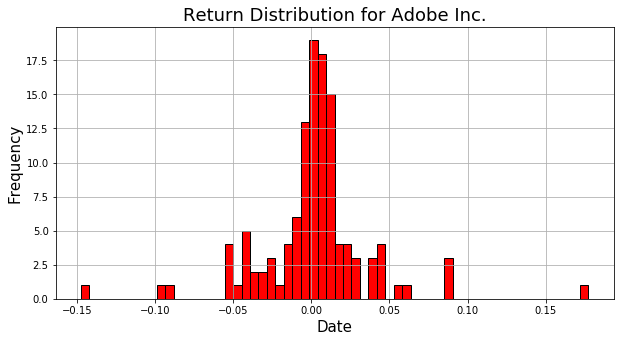

count    120.000000
mean       0.001983
std        0.035808
min       -0.147452
25%       -0.007427
50%        0.003025
75%        0.012791
max        0.177193
Name: close, dtype: float64

In [70]:
# Distribution of Returns for Adobe Inc.
plt.figure(figsize=(10,5))
plt.hist(ADBE_d_returns, color = 'r', edgecolor = 'black', bins = 60)
plt.grid(True)
plt.xlabel('Date', size = 15)
plt.ylabel('Frequency', size = 15)
plt.title("Return Distribution for Adobe Inc.", size = 18)
plt.show()
ADBE_d_returns.describe()

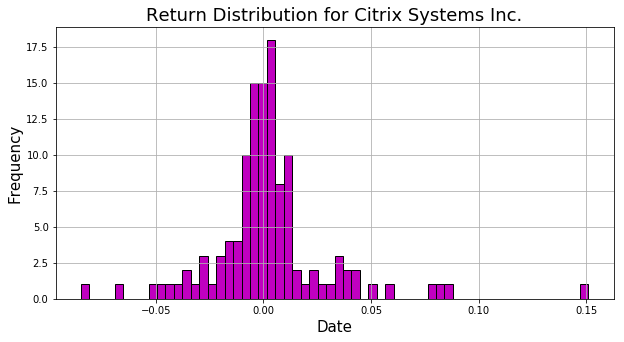

count    120.000000
mean       0.002494
std        0.028220
min       -0.084843
25%       -0.008009
50%        0.000314
75%        0.009404
max        0.150984
Name: close, dtype: float64

In [71]:
# Distribution of Returns for Citrix Systems Inc.
plt.figure(figsize=(10,5))
plt.hist(CTXS_d_returns, color = 'm', edgecolor = 'black', bins = 60)
plt.grid(True)
plt.xlabel('Date', size = 15)
plt.ylabel('Frequency', size = 15)
plt.title("Return Distribution for Citrix Systems Inc.", size = 18)
plt.show()
CTXS_d_returns.describe()

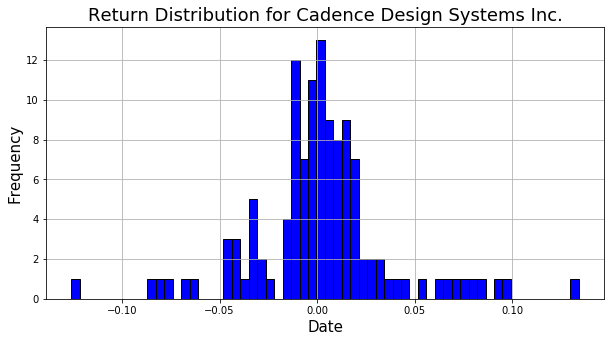

count    120.000000
mean       0.001657
std        0.035891
min       -0.125980
25%       -0.011219
50%        0.000660
75%        0.014963
max        0.133906
Name: close, dtype: float64

In [72]:
# Distribution of Returns for Cadence Design Systems Inc.
plt.figure(figsize=(10,5))
plt.hist(CDNS_d_returns, color = 'b', edgecolor = 'black', bins = 60)
plt.grid(True)
plt.xlabel('Date', size = 15)
plt.ylabel('Frequency', size = 15)
plt.title("Return Distribution for Cadence Design Systems Inc.", size = 18)
plt.show()
CDNS_d_returns.describe()

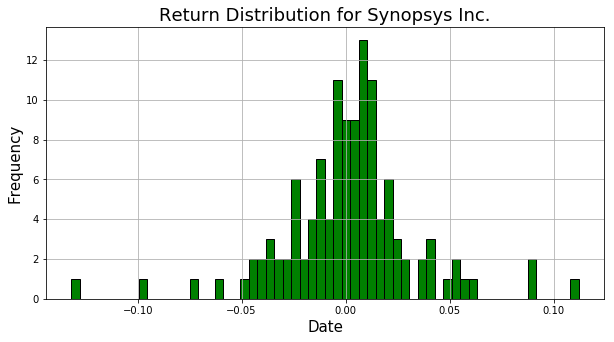

count    120.000000
mean       0.001290
std        0.031837
min       -0.131891
25%       -0.011742
50%        0.002507
75%        0.012894
max        0.112002
Name: close, dtype: float64

In [73]:
# Distribution of Returns for Synopsys Inc.
plt.figure(figsize=(10,5))
plt.hist(SNPS_d_returns, color = 'g', edgecolor = 'black', bins = 60)
plt.grid(True)
plt.xlabel('Date', size = 15)
plt.ylabel('Frequency', size = 15)
plt.title("Return Distribution for Synopsys Inc.", size = 18)
plt.show()
SNPS_d_returns.describe()

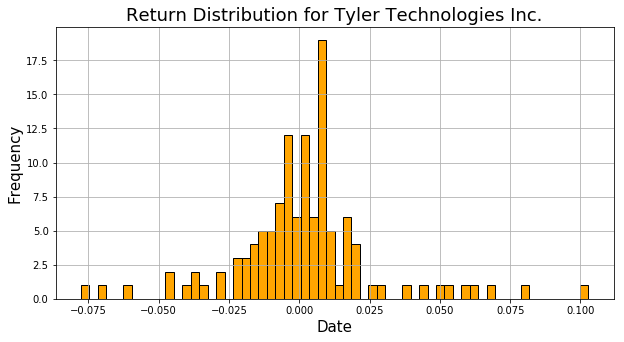

count    120.000000
mean       0.001361
std        0.025365
min       -0.077665
25%       -0.009508
50%        0.001077
75%        0.009143
max        0.102770
Name: close, dtype: float64

In [74]:
# Distribution of Returns for Tyler Technologies Inc.
plt.figure(figsize=(10,5))
plt.hist(TYL_d_returns, color = 'orange', edgecolor = 'black', bins = 60)
plt.grid(True)
plt.xlabel('Date', size = 15)
plt.ylabel('Frequency', size = 15)
plt.title("Return Distribution for Tyler Technologies Inc.", size = 18)
plt.show()
TYL_d_returns.describe()

### Summary of Return Distributions: 
#### The return distributions for all of the 5 companies are ressemble to normal distributions with mean of approximately zero, based on our calculated 119 return data (with 120 trading days we can calculate 119 daily returns). This is in consistent with the above summary of the returns data.
#### The return distribution for the Cadence Design Systems has the biggest standard deviation, which is 0.035891, while Tyler Technologies has the smallest standard deviation, which is 0.025365.

## 2.4 Moving/Window Statistics

###  (a) five day moving average using close price

In [84]:
ADBE_ma5 = ADBE['close'].rolling(5).mean()
CTXS_ma5 = CTXS['close'].rolling(5).mean()
CDNS_ma5 = CDNS['close'].rolling(5).mean()
SNPS_ma5 = SNPS['close'].rolling(5).mean()
TYL_ma5 = TYL['close'].rolling(5).mean()

### (b) five day moving high price (max())

In [85]:
ADBE_max5 = ADBE['close'].rolling(5).max()
CTXS_max5 = CTXS['close'].rolling(5).max()
CDNS_max5 = CDNS['close'].rolling(5).max()
SNPS_max5 = SNPS['close'].rolling(5).max()
TYL_max5 = TYL['close'].rolling(5).max()

### (c) five day moving low price (min())

In [86]:
ADBE_min5 = ADBE['close'].rolling(5).min()
CTXS_min5 = CTXS['close'].rolling(5).min()
CDNS_min5 = CDNS['close'].rolling(5).min()
SNPS_min5 = SNPS['close'].rolling(5).min()
TYL_min5 = TYL['close'].rolling(5).min()

In [87]:
ADBE.loc[:,'MA5'] = ADBE_ma5
CTXS.loc[:,'MA5'] = CTXS_ma5
CDNS.loc[:,'MA5'] = CDNS_ma5
SNPS.loc[:,'MA5'] = SNPS_ma5
TYL.loc[:,'MA5'] = TYL_ma5

ADBE.loc[:,'MAX5'] = ADBE_max5
CTXS.loc[:,'MAX5'] = CTXS_max5
CDNS.loc[:,'MAX5'] = CDNS_max5
SNPS.loc[:,'MAX5'] = SNPS_max5
TYL.loc[:,'MAX5'] = TYL_max5

ADBE.loc[:,'MIN5'] = ADBE_min5
CTXS.loc[:,'MIN5'] = CTXS_min5
CDNS.loc[:,'MIN5'] = CDNS_min5
SNPS.loc[:,'MIN5'] = SNPS_min5
TYL.loc[:,'MIN5'] = TYL_min5

In [120]:
ADBE_windows = pd.DataFrame(ADBE.loc[:, ['close', 'MA5', 'MAX5', 'MIN5']])
ADBE_windows.tail()

,close,MA5,MAX5,MIN5
2020-04-27,348.50,338.746,348.50,328.99
2020-04-28,333.45,339.638,348.50,333.45
2020-04-29,349.17,342.118,349.17,333.45
2020-04-30,353.64,345.772,353.64,333.45
2020-05-01,343.84,345.720,353.64,333.45


In [121]:
CTXS_windows = pd.DataFrame(CTXS.loc[:, ['close', 'MA5', 'MAX5', 'MIN5']])
CTXS_windows.tail()

,close,MA5,MAX5,MIN5
2020-04-27,147.48,146.682,151.69,141.56
2020-04-28,141.19,145.592,151.69,141.19
2020-04-29,139.98,143.250,147.48,139.98
2020-04-30,145.01,143.940,147.48,139.98
2020-05-01,142.58,143.248,147.48,139.98


In [122]:
CDNS_windows = pd.DataFrame(CDNS.loc[:, ['close', 'MA5', 'MAX5', 'MIN5']])
CDNS_windows.tail()

,close,MA5,MAX5,MIN5
2020-04-27,81.31,79.210,81.31,74.59
2020-04-28,78.47,79.986,81.31,78.47
2020-04-29,82.00,80.426,82.00,78.47
2020-04-30,81.13,80.686,82.00,78.47
2020-05-01,75.84,79.750,82.00,75.84


In [123]:
SNPS_windows = pd.DataFrame(SNPS.loc[:, ['close', 'MA5', 'MAX5', 'MIN5']])
SNPS_windows.tail()

,close,MA5,MAX5,MIN5
2020-04-27,154.14,150.944,154.14,144.84
2020-04-28,151.83,152.342,154.14,150.72
2020-04-29,158.01,153.800,158.01,151.83
2020-04-30,157.12,154.826,158.01,151.83
2020-05-01,149.64,154.148,158.01,149.64


In [124]:
TYL_windows = pd.DataFrame(TYL.loc[:, ['close', 'MA5', 'MAX5', 'MIN5']])
TYL_windows.tail()

,close,MA5,MAX5,MIN5
2020-04-27,320.94,317.226,320.94,312.90
2020-04-28,312.01,317.048,320.94,312.01
2020-04-29,320.99,317.602,320.99,312.01
2020-04-30,320.69,317.868,320.99,312.01
2020-05-01,314.78,317.882,320.99,312.01


### 2.5 Plot Daily Close, MA5, MAX5, MIN5 for the five companies

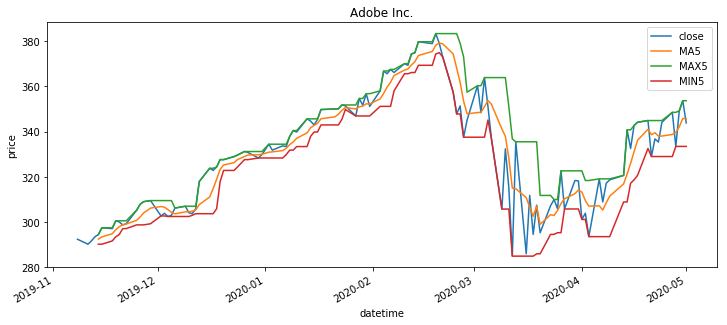

In [97]:
# Adobe Inc.
ADBE[['close','MA5','MAX5','MIN5']].plot(figsize=(12,5))
plt.title("Adobe Inc.")
plt.xlabel("datetime")
plt.ylabel("price")
plt.show()

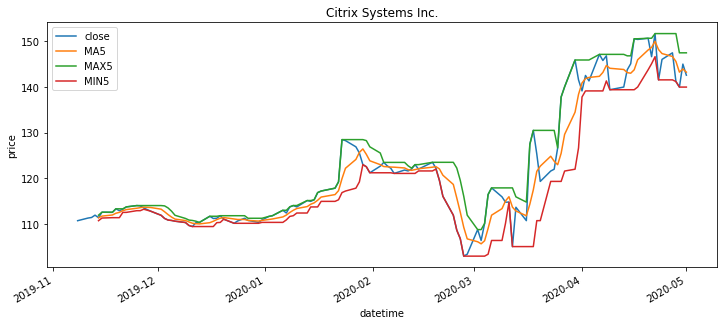

In [98]:
# Citrix Systems Inc.
CTXS[['close','MA5','MAX5','MIN5']].plot(figsize=(12,5))
plt.title("Citrix Systems Inc.")
plt.xlabel("datetime")
plt.ylabel("price")
plt.show()

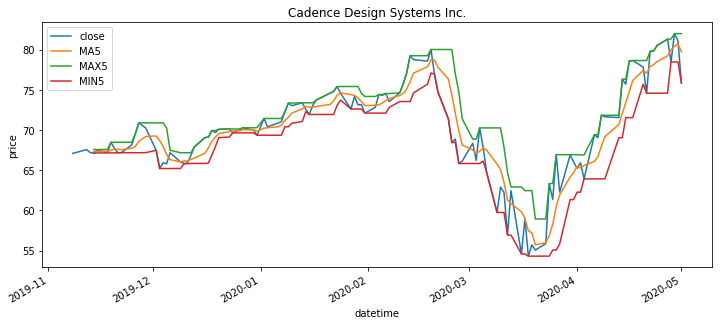

In [99]:
# Cadence Design Systems Inc.
CDNS[['close','MA5','MAX5','MIN5']].plot(figsize=(12,5))
plt.title("Cadence Design Systems Inc.")
plt.xlabel("datetime")
plt.ylabel("price")
plt.show()

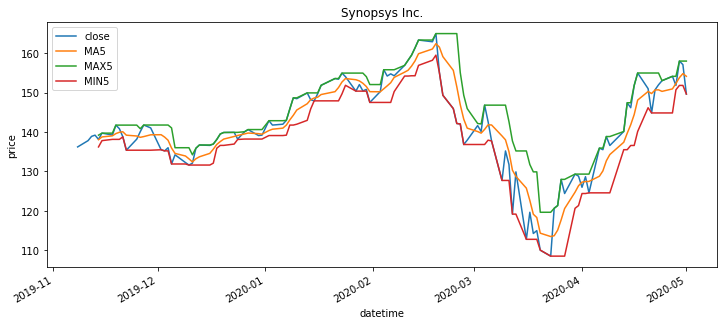

In [100]:
# Synopsys Inc.
SNPS[['close','MA5','MAX5','MIN5']].plot(figsize=(12,5))
plt.title("Synopsys Inc.")
plt.xlabel("datetime")
plt.ylabel("price")
plt.show()

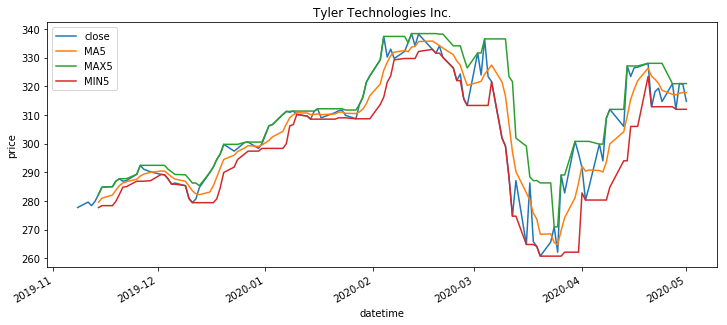

In [101]:
# Tyler Technologies Inc.
TYL[['close','MA5','MAX5','MIN5']].plot(figsize=(12,5))
plt.title("Tyler Technologies Inc.")
plt.xlabel("datetime")
plt.ylabel("price")
plt.show()